# XGBoost Years: clusters using PCA and commercial density as external variable + gridsearch

In [93]:
pip install xgboost

## Import the Data & Modules

In [94]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np
import warnings

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # to set figure size when ploting feature_importance


# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn import preprocessing # scaling data
from sklearn.model_selection import GridSearchCV
#Cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from plotnine import *

In [95]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [96]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_years/WBds03_QUEENtrainYEARS.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_years/WBds03_QUEENpredictYEARS.csv", encoding="utf-8") #2020 prediction df
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")
den_com = pd.read_excel("../../../Other_open_data/densidad comercial.xlsx")

In [97]:
den_com.rename(columns={"Código municipio": "municip_code"}, inplace = True )

In [98]:
den_com = pd.melt(den_com, id_vars=['municip_code'], value_vars=['2019','2018', '2017'], var_name='year', value_name='density')

In [99]:
den_com['density'] = den_com['density'].str.replace( ',', '.')

In [100]:
den_com = den_com.astype({"municip_code": int, "year": int, "density": float})

In [101]:
queen_train.shape

(224, 40)

In [102]:
wasps = pd.merge(queen_train, den_com, how='left', left_on=['municip_code','year_offset'], right_on=['municip_code', 'year'] )

In [103]:
wasps.drop(columns=['year', 'station_code'], inplace=True) 

In [104]:
wasps.shape

(224, 40)

In [105]:
aux = wasps.iloc[:,np.r_[4:31, 39]].copy()

In [106]:
aux.shape

(224, 28)

In [107]:
municip_code = wasps.municip_code
year_offset = wasps.year_offset
NESTS = wasps.NESTS

In [108]:
scalators = list(aux.columns)
aux[scalators] = preprocessing.minmax_scale(aux[scalators])

In [109]:
pca = PCA(n_components = 10)

In [110]:
pca.fit(aux)

PCA(n_components=10)

In [111]:
var = pca.explained_variance_ratio_
var = np.cumsum(np.round(var, decimals=4)*100)
var

array([17.39, 31.52, 42.63, 50.92, 58.51, 64.3 , 69.34, 73.67, 77.52,
       80.94])

In [112]:
projected = pca.transform(aux)
projected = pd.DataFrame(projected)
projected.columns = ["PC1","PC2", "PC3","PC4","PC5","PC6", "PC7", "PC8", "PC9", "PC10"]
projected["NESTS"] = NESTS.astype(object)
projected["municip_code"] = municip_code.astype(object)
projected["year_offset"] = year_offset.astype(object)
projected = projected.loc[projected.year_offset==2018,:].copy()


In [113]:
projected.shape

(112, 13)

In [114]:
X_k = projected.loc[:,["PC1","PC2", "PC3","PC4","PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]]

In [115]:
X_k.shape

(112, 10)

In [116]:
silhouettes = []

for i in range(2,10,1):
  model = KMeans(n_clusters=i)
  X_k = projected.loc[:,["PC1","PC2", "PC3","PC4","PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]]
  model.fit(X_k)
  labels = model.labels_
  sol = silhouette_score(X_k, labels)
  silhouettes.append(sol)

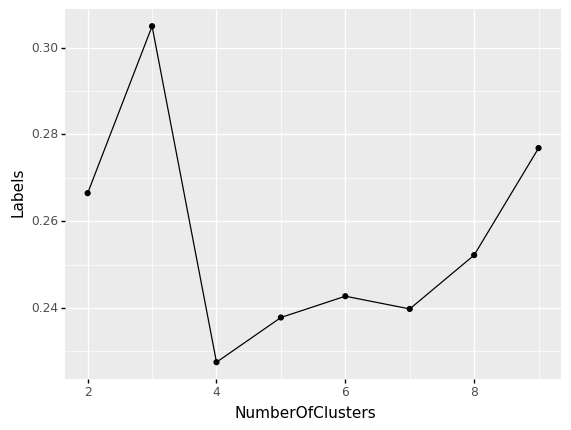

<ggplot: (141928915562)>

In [117]:
silhouette = pd.DataFrame()
silhouette['Labels'] = silhouettes
silhouette['NumberOfClusters'] = range(2,10,1)

ggplot(aes(x='NumberOfClusters', y='Labels'), silhouette) + geom_line() + geom_point()

In [118]:
kmeans = KMeans(n_clusters = 3, random_state = 0)

In [119]:
kmeans.fit(X_k)

KMeans(n_clusters=3, random_state=0)

In [120]:
len(kmeans.labels_)

112

In [121]:
projected['cluster'] = pd.Series(kmeans.labels_, index = projected.index)

In [122]:
cluster = projected.loc[:,['municip_code', 'cluster', 'year_offset']].groupby(by=['municip_code','cluster'], as_index = False).count()

In [123]:
cluster.drop(columns=['year_offset'], inplace=True) 

In [124]:
cluster.municip_code.nunique()

112

In [125]:
cluster.drop_duplicates(inplace=True)

In [126]:
cluster.shape

(112, 2)

In [127]:
wasps = pd.merge(wasps, cluster, how="left", on="municip_code")

In [128]:
wasps.shape

(224, 41)

In [129]:
wasps.head(1)

,municip_name,municip_code,year_offset,NESTS,colonies_amount,food_fruit,food_apple,food_txakoli,food_kiwi,food_pear,...,cluster_size,cluster_cosmo,cluster_survive,cluster_food,cluster_weather_wet,cluster_weather_temp,cluster_weather_wind,cluster_weather_level,density,cluster
0,Abadiño,48001,2017,54,160.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,1,0,0,8.37,0


In [130]:
X_train = wasps.iloc[:,np.r_[4:31, 39, 40]]

In [131]:
X_train.head(2)

,colonies_amount,food_fruit,food_apple,food_txakoli,food_kiwi,food_pear,food_blueberry,food_raspberry,weath_days_frost,weath_humidity,...,weath_meanTemp,weath_maxTemp,weath_maxMeanTemp,weath_minTemp,weath_meanWindM,weath_maxWindM,weath_meanDayMaxWind,population,density,cluster
0,160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,78.058333,...,13.283333,38.4,26.1,0.8,10.868514,82.102336,40.190008,7522,8.37,0
1,160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,79.491667,...,13.675000,37.0,26.6,2.2,11.036587,76.642772,40.302092,7533,8.19,0


In [132]:
X_train.shape

(224, 29)

In [133]:
y_train = wasps.iloc[:,[3,40]]

In [134]:
y_train.shape

(224, 2)

In [135]:
X_0 = X_train.loc[X_train.cluster == 0 ,:]
y_0 = y_train.loc[X_train.cluster == 0 ,'NESTS']

X_1 = X_train.loc[X_train.cluster == 1 ,:]
y_1 = y_train.loc[X_train.cluster == 1 ,'NESTS']

X_2 = X_train.loc[X_train.cluster == 2 ,:]
y_2 = y_train.loc[X_train.cluster == 2 ,'NESTS']


In [136]:
queen_predict.shape

(112, 40)

In [137]:
queen_predict = pd.merge(queen_predict, den_com, how='left', left_on=['municip_code'], right_on=['municip_code'] )

In [138]:
queen_predict = queen_predict.loc[queen_predict.year == 2019,:]

In [139]:
queen_predict = pd.merge(queen_predict, cluster, how='left', on='municip_code')

In [140]:
queen_predict.head(2)

,municip_name,municip_code,year_offset,NESTS,colonies_amount,food_fruit,food_apple,food_txakoli,food_kiwi,food_pear,...,cluster_cosmo,cluster_survive,cluster_food,cluster_weather_wet,cluster_weather_temp,cluster_weather_wind,cluster_weather_level,year,density,cluster
0,Abadiño,48001,2019,0,160.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,1,0,0,2019,7.60,0
1,Abanto y Ciérvana-Abanto Zierbena,48002,2019,0,161.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,1,1,0,2019,6.66,1


In [141]:
queen_predict.drop(columns=['station_code'], inplace=True) 

In [142]:
queen_predict_0 = queen_predict.loc[queen_predict.cluster == 0, :].copy(True)
queen_predict_1 = queen_predict.loc[queen_predict.cluster == 1 , :].copy(True)
queen_predict_2 = queen_predict.loc[queen_predict.cluster == 2 ,:].copy(True)

In [143]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor(random_state=0, objective="reg:squarederror")

In [144]:
# Use GridSearchCV that will automatically split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {
              "learning_rate": [0.2], 
              "max_depth": [6],
              "gamma" : [0.5],
              #"max_delta_step" : [3],
              "min_child_weight": [9],
              #"subsample": [0.9],
              #"colsample_bytree": [0.4],
              "reg_lambda" : [1.5],
              "n_estimators": [200],
              "scale_pos_weight" : [3.5]
              }

warnings.filterwarnings(action='ignore', category=UserWarning)
grid = GridSearchCV(model, param_grid, cv=3)

#2) Fitting the model with our desired data and check for best results
grid.fit(X_0, y_0)

#) Retrieve the summary of GridSearchCV for analysis
print(F"The number homogeneous splits conducted by GridSearchCV are: {grid.n_splits_}.")
print(F"The best hyperparameters found were: {grid.best_params_}.")
print(F"The best score found was: {grid.best_score_}.")

The number homogeneous splits conducted by GridSearchCV are: 3.
The best hyperparameters found were: {'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 200, 'reg_lambda': 1.5, 'scale_pos_weight': 3.5}.
The best score found was: -0.47901077003862325.


In [145]:
# Reset warnigns to default (this is used to suppred a warning message from XGBoost model and avoid converting X_train to numpy to keep features name)

warnings.filterwarnings(action='default', category=UserWarning)

In [146]:
model = grid.best_estimator_
model.fit(X_0, y_0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1.5, scale_pos_weight=3.5, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

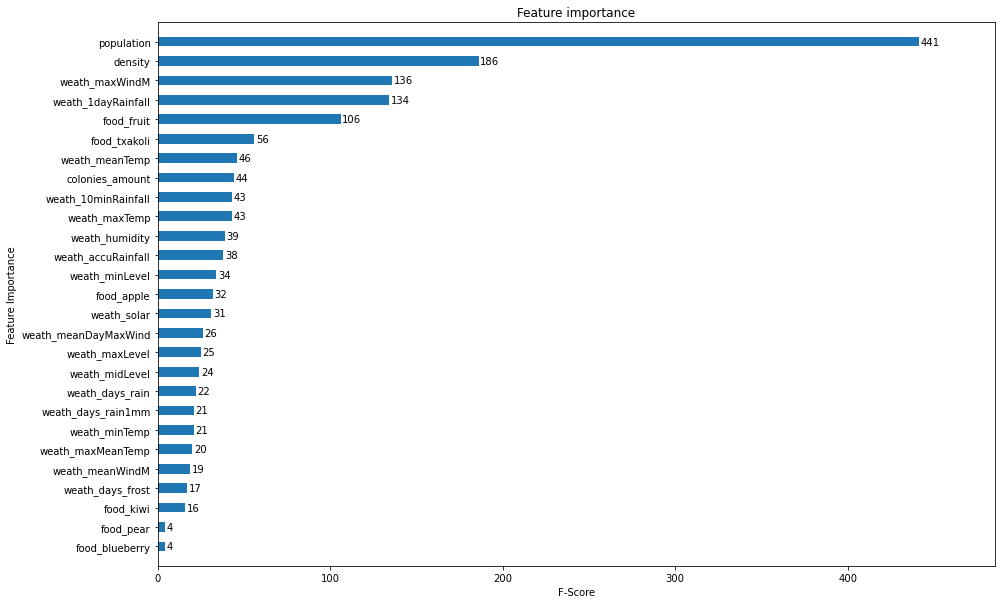

In [147]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

In [148]:
X_0.columns

Index(['colonies_amount', 'food_fruit', 'food_apple', 'food_txakoli',
       'food_kiwi', 'food_pear', 'food_blueberry', 'food_raspberry',
       'weath_days_frost', 'weath_humidity', 'weath_maxLevel',
       'weath_midLevel', 'weath_minLevel', 'weath_days_rain',
       'weath_days_rain1mm', 'weath_accuRainfall', 'weath_10minRainfall',
       'weath_1dayRainfall', 'weath_solar', 'weath_meanTemp', 'weath_maxTemp',
       'weath_maxMeanTemp', 'weath_minTemp', 'weath_meanWindM',
       'weath_maxWindM', 'weath_meanDayMaxWind', 'population', 'density',
       'cluster'],
      dtype='object')

In [149]:
model.fit(X_0.loc[:,['population','density', 'weath_maxWindM', 'weath_1dayRainfall', 'food_fruit']],y_0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1.5, scale_pos_weight=3.5, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [150]:
predictions_0 = model.predict(queen_predict_0.loc[:,['population','density', 'weath_maxWindM', 'weath_1dayRainfall', 'food_fruit']])

In [151]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor(random_state=0, objective="reg:squarederror")

In [152]:
# Use GridSearchCV that will automatically split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {
              "learning_rate": [0.2], 
              "max_depth": [6],
              "gamma" : [0.5],
              #"max_delta_step" : [3],
              "min_child_weight": [9],
              #"subsample": [0.9],
              #"colsample_bytree": [0.4],
              "reg_lambda" : [1.5],
              "n_estimators": [200],
              "scale_pos_weight" : [3.5]
              }

warnings.filterwarnings(action='ignore', category=UserWarning)
grid = GridSearchCV(model, param_grid, cv=3)

#2) Fitting the model with our desired data and check for best results
grid.fit(X_1, y_1)

#) Retrieve the summary of GridSearchCV for analysis
print(F"The number homogeneous splits conducted by GridSearchCV are: {grid.n_splits_}.")
print(F"The best hyperparameters found were: {grid.best_params_}.")
print(F"The best score found was: {grid.best_score_}.")

The number homogeneous splits conducted by GridSearchCV are: 3.
The best hyperparameters found were: {'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 200, 'reg_lambda': 1.5, 'scale_pos_weight': 3.5}.
The best score found was: -0.3703771562758928.


In [153]:
# Reset warnigns to default (this is used to suppred a warning message from XGBoost model and avoid converting X_train to numpy to keep features name)

warnings.filterwarnings(action='default', category=UserWarning)

In [154]:
model = grid.best_estimator_
model.fit(X_1, y_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1.5, scale_pos_weight=3.5, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

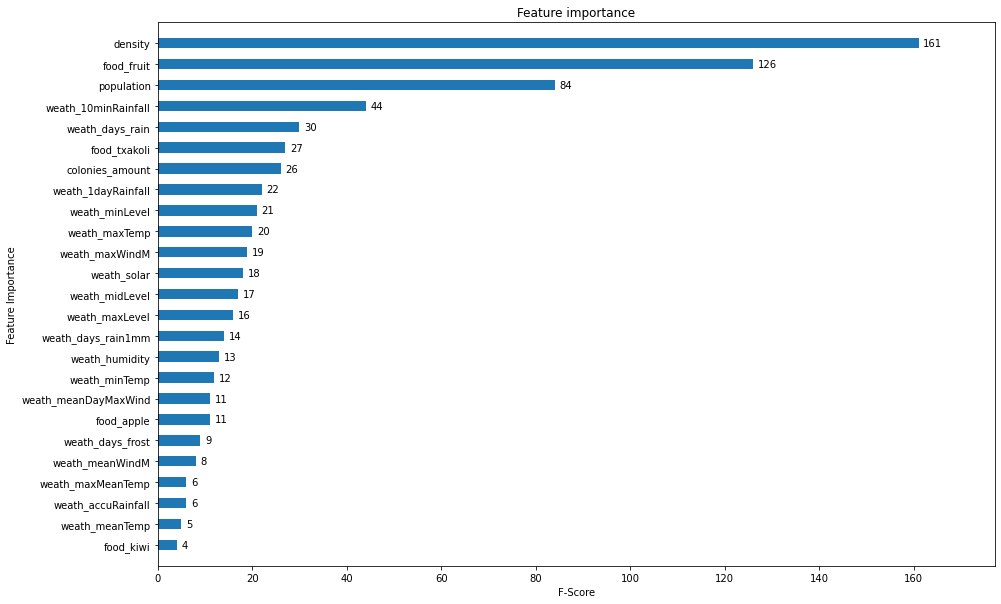

In [155]:
plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

In [156]:
model.fit(X_1.loc[:,['density', 'food_fruit', 'population']],y_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1.5, scale_pos_weight=3.5, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [157]:
predictions_1 = model.predict(queen_predict_1.loc[:,['density', 'food_fruit', 'population']])

In [158]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor(random_state=0, objective="reg:squarederror")

In [159]:
# Use GridSearchCV that will automatically split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {
              "learning_rate": [0.2], 
              "max_depth": [6],
              "gamma" : [0.5],
              #"max_delta_step" : [3],
              "min_child_weight": [9],
              #"subsample": [0.9],
              #"colsample_bytree": [0.4],
              "reg_lambda" : [1.5],
              "n_estimators": [200],
              "scale_pos_weight" : [3.5]
              }

warnings.filterwarnings(action='ignore', category=UserWarning)
grid = GridSearchCV(model, param_grid, cv=3)

#2) Fitting the model with our desired data and check for best results
grid.fit(X_2, y_2)

#) Retrieve the summary of GridSearchCV for analysis
print(F"The number homogeneous splits conducted by GridSearchCV are: {grid.n_splits_}.")
print(F"The best hyperparameters found were: {grid.best_params_}.")
print(F"The best score found was: {grid.best_score_}.")

The number homogeneous splits conducted by GridSearchCV are: 3.
The best hyperparameters found were: {'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 200, 'reg_lambda': 1.5, 'scale_pos_weight': 3.5}.
The best score found was: -2.8911030324854727.


In [160]:
# Reset warnigns to default (this is used to suppred a warning message from XGBoost model and avoid converting X_train to numpy to keep features name)

warnings.filterwarnings(action='default', category=UserWarning)

In [161]:
model = grid.best_estimator_
model.fit(X_2, y_2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1.5, scale_pos_weight=3.5, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

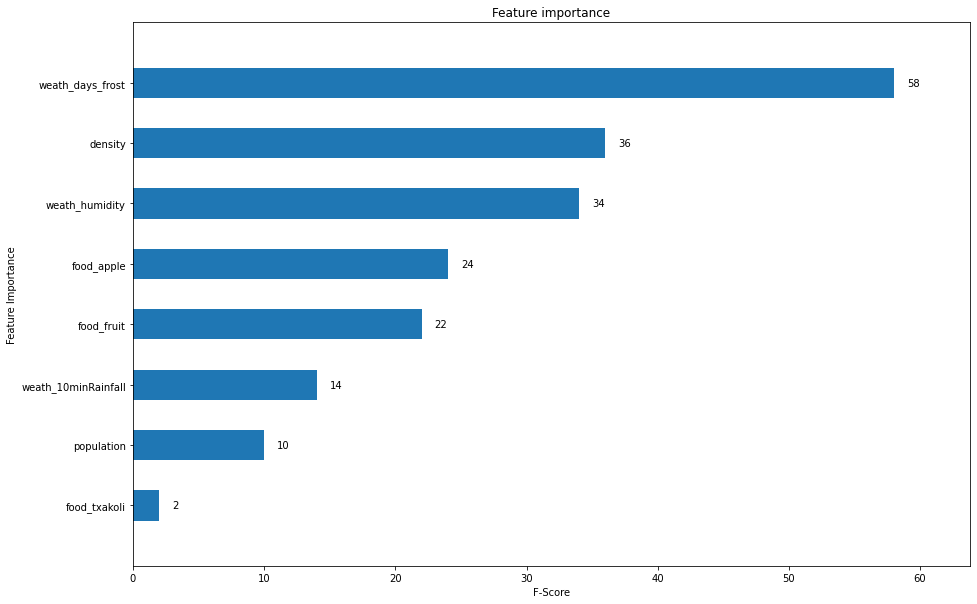

In [162]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

In [163]:
model.fit(X_2.loc[:,['weath_days_frost','density','weath_humidity']],y_2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1.5, scale_pos_weight=3.5, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [164]:
predictions_2 = model.predict(queen_predict_2.loc[:,['weath_days_frost','density','weath_humidity']])

In [165]:
queen_predict_0['nests_2020'] = predictions_0
queen_predict_1['nests_2020'] = predictions_1
queen_predict_2['nests_2020'] = predictions_2

In [166]:
HEX_0 = queen_predict_0.loc[:,['municip_code','municip_name','nests_2020']].groupby(by=['municip_code','municip_name'], as_index=False).sum().round().dropna()
HEX_1 = queen_predict_1.loc[:,['municip_code','municip_name','nests_2020']].groupby(by=['municip_code','municip_name'], as_index=False).sum().round().dropna()
HEX_2 = queen_predict_2.loc[:,['municip_code','municip_name','nests_2020']].groupby(by=['municip_code','municip_name'], as_index=False).sum().round().dropna()

In [167]:
HEX = HEX_0.append(HEX_1, ignore_index = True).append(HEX_2, ignore_index = True)

In [168]:
#HEX.loc[HEX.municip_code.isin([48020,48071, 48088]),'nests_2020']= 0
#HEX.loc[HEX.municip_code.isin([48022,48074, 48051]),'nests_2020']= 1

In [169]:
HEX.columns = ['CODIGO MUNICIPIO','NOMBRE MUNICIPIO','NIDOS 2020']

In [170]:
# Final check

check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2781


'All Municipality Names and Codes to be submitted match the Template'

In [171]:
HEX.head()

,CODIGO MUNICIPIO,NOMBRE MUNICIPIO,NIDOS 2020
0,48001,Abadiño,18.0
1,48003,Amorebieta-Etxano,76.0
2,48004,Amoroto,3.0
3,48005,Arakaldo,2.0
4,48006,Arantzazu,0.0


In [172]:
# Save the new dataFrame as a .csv in the current working directory
HEX.to_csv("WaspBusters_20210609_XG_Bowser_Grid.csv", index=False)